In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py

os.chdir('/content')
print("Current working directory", os.getcwd())

--2023-11-08 18:43:05--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15061 (15K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]  14.71K  --.-KB/s    in 0.001s  

2023-11-08 18:43:05 (23.3 MB/s) - ‘models.py’ saved [15061/15061]

--2023-11-08 18:43:06--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6436 (6.3K) [text/plain]
Savi

In [ ]:
from utils import vision
from utils import utils
from utils import losses

### Experiment Parameters

In [ ]:
experiment = {
    'TYPE': 'train',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'GPU',   # 'CPU', 'GPU' or 'TPU'

    'IMAGE_SIZE': (512, 512),
    'INPUT_SHAPE': (512, 512, 3),
    'VALID_SIZE': 0.1,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': True,       # Apply data augmentation

    'BACKBONE': 'custom',        # 'custom', 'VGG16', 'VGG19' - default 'custom'
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'BATCH_SIZE': 16,            # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 1000,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 1e-4,

    'RECONS_LOSS': 'PERCEPTUAL',  # Reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    'PERCEPTUAL_LAYERS': [5,8,13,18],    # [5,8,13,18], None
    'PERCEP_LOSS_MODEL': 'VGG19', # custom', 'VGG16', 'VGG19' - default 'VGG16'
    'PERP_LOSS_LAMBDA': 1,
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    'MSE_LOSS_LAMBDA': 0.01,  # MSE coeff

    # set the dimensionality of the latent space to a plane for visualization later
    'LATENT_DIM': 500,

    'SAVE_WEIGHTS_PER_EPOCH': 10,
    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "autoencoder_model/BD67_dataset/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "autoencoder_model/BD67_dataset/images",
}

### Determining Reconstructing Loss Function

* **MSE** (Mean Squared Error): Pixel-Wise Reconstruction Loss, L2 rergularization (Ridge)
MSE = Σ (pixel_original - pixel_reconstructed)^2 / N

* **MAE** (Mean Absolute Error): Pixel-Wise Reconstruction Loss, L1 rergularization (Lasso)
MAE = Σ (pixel_original - pixel_reconstructed) / N

* **Feature-Wise Reconstruction Loss**: A common approach is to use a `perceptual loss` or `content loss`, which compares the high-level features or activations of intermediate layers of a pre-trained neural network
1. Encode the input image into a latent vector using the pre-trained model (encoder). Ex. `VGG19 model`

2. Reconstruct an image from latent vector using the decoder.

3. Calculate the loss based on the similarity between the input image and the reconstructed image.

In [ ]:
if experiment['ACCELERATOR'] == 'TPU':
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(resolver)

    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    # Increase batch_size to improve the efficiency provided by TPU usage
    experiment['BATCH_SIZE'] = experiment['BATCH_SIZE'] * strategy.num_replicas_in_sync
    print("All devices:  ", tf.config.list_logical_devices('TPU'))
    print("All replicas: ", strategy.num_replicas_in_sync)
else:
    strategy = tf.distribute.get_strategy()

In [ ]:
per_replica_batch_size = experiment['BATCH_SIZE'] // strategy.num_replicas_in_sync

In [ ]:
print("Number of cores(replicas) in sync: ", strategy.num_replicas_in_sync)
print("Batch size: ", experiment['BATCH_SIZE'])
print("Batch size per replica: ", per_replica_batch_size)

Number of cores(replicas) in sync:  1
Batch size:  16
Batch size per replica:  16


In [ ]:
ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'
TFRECORD_TRAIN_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images.tfrecords'
TFRECORD_TEST_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images_test.tfrecords'

In [ ]:
import os

BD67_NORMAL_PATH = os.path.join(DATASET_PATH, 'defect_free')
BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/cropped')
BD67_NORMAL_FRONT_ROTATED_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/rotated_images/cropped')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front/cropped')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')

### Read TFRecord File

In [ ]:
import shutil

if experiment['ACCELERATOR'] == 'TPU':
    # Use the shutil.copy() method to copy the TFRecord file in Google drive to the local workspace
    shutil.copy(TFRECORD_TRAIN_PATH, ROOT_PATH)
    shutil.copy(TFRECORD_TEST_PATH, ROOT_PATH)

In [ ]:
TFRECORD_TRAIN_PATH_LOCAL = '/content/images.tfrecords'
TFRECORD_TEST_PATH_LOCAL = '/content/images_test.tfrecords'

In [ ]:
# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

In [ ]:
# Returns "File system scheme '[local]' not implemented (file: '/bufferedio/content/images.tfrecords')" Error
# The dataset should be stored in GCS (Google Cloud Storage)
# image_dataset = read_tfRecord_image('/content/images.tfrecords', image_feature_description)

### Prepare Data

In [ ]:
img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_PATH, 'png')
rotated_img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_ROTATED_PATH, 'png')
all_img_files = img_files + rotated_img_files

print("Number of flat image files: ", len(img_files))
print("Number of rotated image files: ", len(rotated_img_files))
print("Number of all image files: ", len(all_img_files))

Number of flat image files:  110
Number of rotated image files:  105
Number of all image files:  215


### Data Augmentation Layer

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"), # randomly flip images on horizontal/vertical edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  tf.keras.layers.RandomBrightness(factor=0.2, value_range=[0.0, 1.0], seed=None),
  # value_range parameter should be [0.0, 1.0] for RandomBrightness
  # if images were scaled before, default value is [0,255]
  #tf.keras.layers.RandomContrast(0.2, seed=None),
  #tf.keras.layers.RandomCrop(256, 256, seed=None), Error - Image size changes
  #preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  #preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  #preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [ ]:
def apply_augmentation(image):
    image = data_augmentation(image, training=True)  # Apply data augmentation layers
    return image

In [ ]:
train_dataset = utils.create_dataset_pipeline(img_files, batch_size=experiment['BATCH_SIZE'], img_size=experiment['IMAGE_SIZE'], scl=True, shuffle=False, num_channels=3, rot=utils.ROT_0, duplicate=True, aug_layer=None, data_aug_power=1, accelerator='GPU')

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None))>

In [ ]:
print("Number of batches to be trained: ", len(train_dataset))

Number of batches to be trained:  7


* The `cache()` method is used to cache elements of a dataset in memory or on disk. Caching allows you to `store a portion` or the entire `dataset` in a format that can be quickly accessed during training `without repeatedly reading the data from its source` (e.g., files on disk). It helps reduce data loading time during training. When you call dataset.cache(), it caches the dataset's elements in memory by default. If you want to cache to disk, you can provide a filename as an argument to the cache() method. Caching can significantly speed up training if data loading is a bottleneck in your pipeline.

* The `prefetch()` method is used to `overlap data loading` and model training, which can lead to improved training performance. When you prefetch data, the dataset pipeline `fetches` the `next batch` of data asynchronously `while the current batch is being processed` by the model. This can help hide data loading latency and ensure that the GPU or CPU is fully utilized during training.

* `tf.data.experimental.AUTOTUNE` is used as an argument to the prefetch() method. This value allows TensorFlow to `dynamically adjust` the number of elements prefetched based on the `available system resources` and workload. It tries to optimize the prefetching for the best performance automatically.

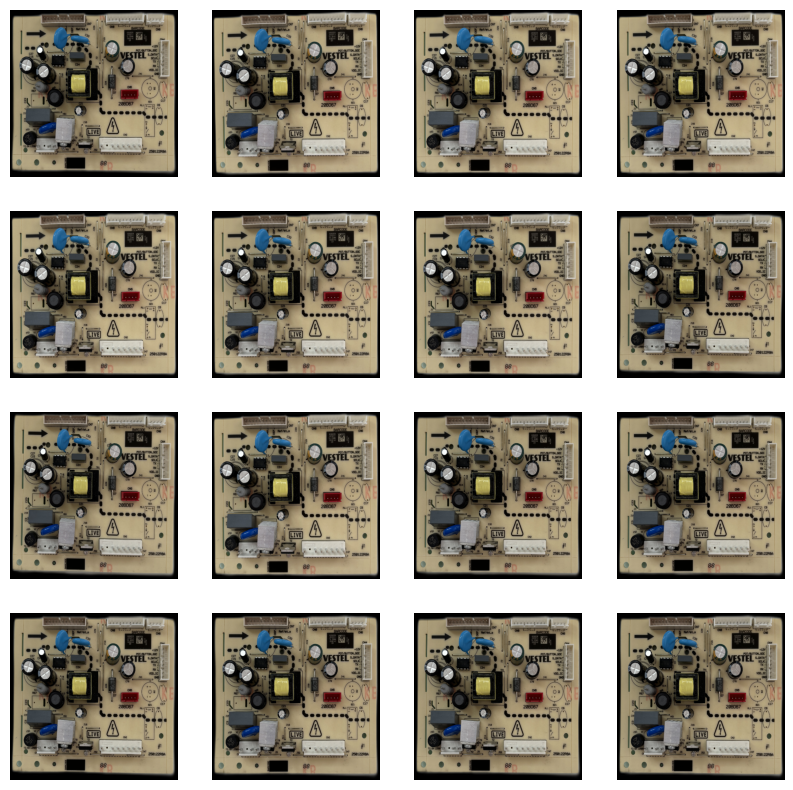

In [ ]:
#vision.show_image_samples_from_batch(train_dataset, grid=(4,4))
image_batch, _ = next(iter(train_dataset))
fig = plt.figure(figsize=(10, 10))

for index, image in enumerate(image_batch):  # Get first batch
  plt.subplot(4, 4, index + 1)
  plt.imshow(image[:, :, :])
  plt.axis('off')
  if index >= (len(image_batch)-1):
    break

### Convolutional Autoencoder Architecture

based on "*Image Based Detection of Modifications in Assembled PCBs with Deep Convolutional Autoencoders*" literature.

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.layers import LeakyReLU, Lambda, ReLU, Concatenate
from tensorflow.keras.models import Model

In [ ]:
def conv_block(x, filters=16, kernel=5, stride=2, transpose=False, slope=experiment['LRELU_SLOPE'], padding='same'):
  conv = Conv2DTranspose if transpose else Conv2D

  x = conv(filters=filters, kernel_size=(kernel,kernel), strides=stride, padding=padding, use_bias=True)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(slope)(x)

  return x

In [ ]:
def create_encoder_model(input_shape, output_shape, verbose=0):
    """ input_shape: Autoencoder model input shape
        output_shape: Latent vector shape
    """
    with strategy.scope():
      n_leves_enc = 7
      n_dense = int(input_shape[0]/(2**n_leves_enc))

      inputs = Input(shape=input_shape, name='encoder_input')
      # Apply Data augmentation
      if experiment['DATA_AUG'] == True:
        inputs = data_augmentation(inputs)

      conv1 = conv_block(inputs, filters=32)
      conv2 = conv_block(conv1,  filters=64)
      conv3 = conv_block(conv2,  filters=128)
      conv4 = conv_block(conv3,  filters=128)
      conv5 = conv_block(conv4,  filters=256)
      conv6 = conv_block(conv5,  filters=256)
      conv7 = conv_block(conv6,  filters=256)

      conv7_flat = Flatten()(conv7)
      fc1 = Dense(units=(n_dense*n_dense*256))(conv7_flat)

      # Batch normalization
      fc1 = BatchNormalization()(fc1)
      # Add activation function Leaky ReLU
      fc1 = LeakyReLU(alpha=experiment['LRELU_SLOPE'])(fc1)

      fc2 = Dense(units=output_shape)(fc1)
      output_layer = LeakyReLU(alpha=experiment['LRELU_SLOPE'])(fc2)

      model = Model(inputs, output_layer, name='Encoder_Model')
    if verbose > 0:
      model.summary()
    return model

In [ ]:
def create_decoder_model(input_shape, output_shape, verbose=0):
    """ input_shape: Latent vector shape
        output_shape: Autoencoder model input shape
    """
    with strategy.scope():
      n_leves_enc = 7
      n_dense = int(output_shape[0]/(2**n_leves_enc))

      inputs = Input(shape=input_shape, name='decoder_input')
      fc1 = Dense(units=(n_dense*n_dense*256))(inputs)
      fc1 = BatchNormalization()(fc1)
      fc1 = LeakyReLU(alpha=experiment['LRELU_SLOPE'])(fc1)

      z_mat = Reshape((n_dense, n_dense, 256))(fc1)

      # Transposed Convolution Layers
      dconv0 = conv_block(z_mat,  filters=256, transpose=True)
      dconv1 = conv_block(dconv0, filters=256, transpose=True)
      dconv2 = conv_block(dconv1, filters=128, transpose=True)
      dconv3 = conv_block(dconv2, filters=128, transpose=True)
      dconv4 = conv_block(dconv3, filters=64, transpose=True)
      dconv5 = conv_block(dconv4, filters=32, transpose=True)

      dconv6 = Conv2DTranspose(filters=output_shape[2], kernel_size=(5,5), strides=2, padding='same',
          use_bias=True, activation='sigmoid')(dconv5)

      model = Model(inputs, dconv6, name="Decoder_Model")
    if verbose > 0:
      model.summary()
    return model

### Create Autoencoder Model

In [ ]:
encoder_model = create_encoder_model(experiment['INPUT_SHAPE'], output_shape=experiment['LATENT_DIM'], verbose=1)

Model: "Encoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      51264     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                    

In [ ]:
latent_input = (experiment['LATENT_DIM'],)

In [ ]:
create_decoder_model(latent_input, output_shape=experiment['INPUT_SHAPE'], verbose=1)

Model: "Decoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 500)]             0         
                                                                 
 dense_2 (Dense)             (None, 4096)              2052096   
                                                                 
 batch_normalization_8 (Bat  (None, 4096)              16384     
 chNormalization)                                                
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         1638656   
 anspose)                                            

In [ ]:
def create_autoencoder_model(input_shape, latent_dim_shape):
    with strategy.scope():
      inputs = Input(shape=input_shape, name='Autoencoder_input')

      enc_model = create_encoder_model(input_shape, latent_dim_shape, verbose=0)
      dec_model = create_decoder_model(latent_dim_shape, input_shape, verbose=0)

      latent_vector = enc_model(inputs)
      output = dec_model(latent_vector)

      model = Model(inputs, output, name="Autoencoder_Model")

    model.summary()
    return model

In [ ]:
autoencoder_model = create_autoencoder_model(experiment['INPUT_SHAPE'],
                                  latent_dim_shape=experiment['LATENT_DIM'])

Model: "Autoencoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Autoencoder_input (InputLa  [(None, 512, 512, 3)]     0         
 yer)                                                            
                                                                 
 Encoder_Model (Functional)  (None, 500)               23615796  
                                                                 
 Decoder_Model (Functional)  (None, 512, 512, 3)       6836803   
                                                                 
Total params: 30452599 (116.17 MB)
Trainable params: 30432247 (116.09 MB)
Non-trainable params: 20352 (79.50 KB)
_________________________________________________________________


In [ ]:
def init_perceptual_loss(perp_layers=None, verbose=0):
  # Set perceptual model
  if experiment['PERCEP_LOSS_MODEL'] == 'VGG19':
    perp_model = tf.keras.applications.VGG19(input_shape=(224,224,3))
  else:
    perp_model = tf.keras.applications.VGG16(input_shape=(224,224,3))

  # Set perceptual loss output layers
  if perp_layers != None:
    modelOutputs = [perp_model.layers[i].output for i in perp_layers]
  else:
    modelOutputs = perp_model.layers[-2].output  # Get last layer of the model before prediction layer

  model = Model(perp_model.inputs, modelOutputs)
  if verbose > 0:
      model.summary()

  return model

In [ ]:
# vgg19_model = init_perceptual_loss([5,8,13,18], 1)

# print(f'VGG19 Model layers that will be used for Perceptual Loss are: \n\
#  {vgg19_model.layers[5]}\n {vgg19_model.layers[8]}\n\
#  {vgg19_model.layers[13]}\n {vgg19_model.layers[18]}')

# vgg19_model = init_perceptual_loss(None, 1)
# print(f'VGG19 Model layers that will be used for Perceptual Loss are: \n\
#  {vgg19_model.layers[-1]}')

### Loss Functions and Optimizer

### MSE Perceptual Loss

Perceptual Loss

In short, the perceptual loss function works by `summing` all the `squared errors` between all the `pixels` and `taking the mean`. This is in contrast to a `per-pixel loss function` which sums all the absolute errors between pixels.


[What is a Perceptual Loss Function?](https://deepai.org/machine-learning-glossary-and-terms/perceptual-loss-function)

[Johnson et al. (2016)](https://arxiv.org/pdf/1603.08155.pdf%7C)

In [ ]:
class MSE_Perceptual(tf.keras.losses.Loss):
  def __init__(self, perc_layers=None, lambda_mse=0.01, lambda_perc=1, perc_loss=False):
    super(MSE_Perceptual, self).__init__()
    self.loss = None
    self.perc_layers = perc_layers
    self.lambda_mse = lambda_mse
    self.perc_loss = perc_loss
    self.lambda_perc = lambda_perc
    with strategy.scope():  # TPU
      self.perc_model = init_perceptual_loss(self.perc_layers)
      self.loss_fn = tf.keras.losses.mean_squared_error

  def call(self, y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(tf.math.pow(y_pred,2) - tf.math.pow(y_true,2)))

    if self.perc_loss == True:
        perceptual_loss = []

        y_true_reshape = tf.image.resize(y_true, (224, 224))
        y_pred_reshape = tf.image.resize(y_pred, (224, 224))

        y_true_output = self.perc_model(y_true_reshape)
        y_pred_output = self.perc_model(y_pred_reshape)

        if self.perc_layers != None:
            # Add losses for every perceptual layer output
            for idx, (y_true_layer, y_pred_layer) in enumerate(zip(y_true_output, y_pred_output)):
                  # Output (Layer 5): (8, 112, 112, 128)
                  # Output (Layer 8): (8, 56, 56, 256)
                  # Output (Layer 13): (8, 28, 28, 512)
                  # Output (Layer 18): (8, 14, 14, 512)
                  # y_pred_layer[0].shape = (112, 112, 128) for Layer 5
                  w, h, d = y_pred_layer[0].shape
                  perceptual_loss.append((1/(w*h*d))*tf.reduce_mean(tf.square(y_true_layer - y_pred_layer)))
                  #perceptual_loss.append((1/(w*h*d))*tf.reduce_sum(tf.square(y_true_layer - y_pred_layer)))
        else:
            # Last layer of the backbone, flatten layer
            # y_pred_layer.shape: (4096,) => y_pred_layer.shape[0]: 4096
            perceptual_loss.append((1/y_pred_output.shape[0])*tf.reduce_mean(tf.square(y_true_output - y_pred_output)))
            # perceptual_loss.append((1/y_pred_output.shape[0])*tf.reduce_sum(tf.square(y_true_output - y_pred_output)))

    self.loss = self.lambda_mse*mse_loss
    if self.perc_loss == True:
        self.loss += self.lambda_perc*tf.reduce_sum(perceptual_loss)

    return self.loss

### Create Loss Function

In [ ]:
if (experiment['RECONS_LOSS'] == 'PERCEPTUAL'):
  loss_fn = MSE_Perceptual(experiment['PERCEPTUAL_LAYERS'], experiment['MSE_LOSS_LAMBDA'], experiment['PERP_LOSS_LAMBDA'], perc_loss=True)
else:
  loss_fn = MSE_Perceptual(lambda_mse=experiment['MSE_LOSS_LAMBDA'])

574710816/574710816 [==============================] - 4s 0us/step


In [ ]:
from glob import glob

training_files = glob(BD67_NORMAL_FRONT_PATH + "/*.png")
print(f"Number of normal BD67-PCB front side photos: {len(training_files)}")

Number of normal BD67-PCB front side photos: 110


In [ ]:
from sklearn.model_selection import train_test_split

training_files, valid_files, _, _ = train_test_split(training_files, training_files, test_size=experiment['VALID_SIZE'], random_state=100)

print(f"Number of Training Images: {len(training_files)}")
print(f"Number of Validation Images: {len(valid_files)}")

Number of Training Images: 99
Number of Validation Images: 11


In [ ]:
import math

training_batch_num = len(train_dataset) - math.ceil(len(train_dataset) * experiment['VALID_SIZE'])

train_dataset_part = train_dataset.take(training_batch_num)
valid_dataset_part = train_dataset.skip(training_batch_num)

print("Number of training batches:   ", len(train_dataset_part))
print("Number of validation batches: ", len(valid_dataset_part))

Number of training batches:    6
Number of validation batches:  1


### Learning Rate Decay

In [ ]:
import math

LR_START = 1e-5
LR_MIN = 1e-5
#LR_MAX = 9e-4 * strategy.num_replicas_in_sync
LR_MAX = 9e-4
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = 0.5
EPOCHS = experiment['EPOCHS']

def lrfn(epoch):
  if epoch < LR_RAMPUP_EPOCHS:
    lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
  elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
    lr = LR_MAX
  else:
    progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
    lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
    if LR_MIN is not None:
      lr = tf.math.maximum(LR_MIN, lr)

  return lr

### Training Callbacks

In [ ]:
lr_callback2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
cp = tf.keras.callbacks.ModelCheckpoint(filepath=f"{experiment['TRAINING_WEIGHT_DIR']}/best_model_val_loss.h5", monitor='val_loss', save_best_only=True)

In [ ]:
STEPS_PER_EPOCH = len(training_files) // experiment['BATCH_SIZE']
STEPS_PER_VAL = len(valid_files) // experiment['BATCH_SIZE'] + 1

print("STEPS_PER_EPOCH: ", STEPS_PER_EPOCH)
print("STEPS_PER_VAL: ", STEPS_PER_VAL)

STEPS_PER_EPOCH:  6
STEPS_PER_VAL:  1


In [ ]:
if experiment['TYPE'] == 'train':
    if (experiment['RECONS_LOSS'] == 'MSE') or (experiment['RECONS_LOSS'] == 'PERCEPTUAL'):
      with strategy.scope():
        autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(),
                              # Anything between 2 and `steps_per_epoch` could help here.
                              steps_per_execution = 50,
                              loss=loss_fn,
                              metrics=['mae', 'mse'])
    elif experiment['RECONS_LOSS'] == 'SSIM':
      with strategy.scope():
        autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(),
                              steps_per_execution = 50,
                              loss=losses.ssim_loss,
                              metrics=['mae', 'mse'])

In [ ]:
if experiment['TYPE'] == 'train':
    autoencoder_model_hist = autoencoder_model.fit(
        train_dataset_part,
        validation_data=valid_dataset_part,
        epochs=experiment['EPOCHS'],
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[lr_callback2, cp],
        validation_steps=STEPS_PER_VAL
      )


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/1000
6/6 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.2489 - mse: 0.0969

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 24s 4s/step - loss: 0.0011 - mae: 0.2489 - mse: 0.0969 - val_loss: 8.6304e-04 - val_mae: 0.2287 - val_mse: 0.0802 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 0.0003066666666666667.
Epoch 2/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0010 - mae: 0.2445 - mse: 0.0933 - val_loss: 8.6197e-04 - val_mae: 0.2285 - val_mse: 0.0800 - lr: 3.0667e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0006033333333333333.
Epoch 3/1000
6/6 [==============================] - 5s 824ms/step - loss: 8.9480e-04 - mae: 0.2319 - mse: 0.0831 - val_loss: 8.6023e-04 - val_mae: 0.2281 - val_mse: 0.0796 - lr: 6.0333e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008999999845400453.
Epoch 4/1000
6/6 [==============================] - 5s 850ms/step - loss: 7.8127e-04 - mae: 0.2206 - mse: 0.0727 - val_loss: 8.5743e-04 - val_mae: 0.2274 - val_mse: 0.0788 - lr: 9.0000e-04

Epoch 5: LearningRateSchedule

In [ ]:
import pandas as pd

if experiment['TYPE'] == 'train':
  pd.DataFrame.from_dict(autoencoder_model_hist.history).to_csv(f"{experiment['TRAINING_WEIGHT_DIR']}/model_history.csv", index=False)

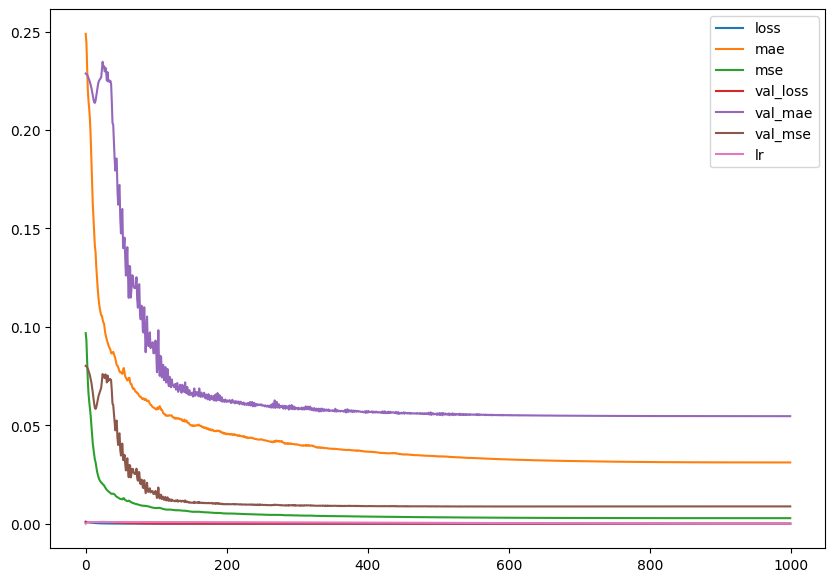

In [ ]:
if experiment['TYPE'] == 'train':
  pd.DataFrame(autoencoder_model_hist.history).plot(figsize=(10, 7))

### Run model in Inference mode - Prediction

In [ ]:
def predict_perpdiff(dataset, ds_imgs, model):
  vgg19_perp_model = tf.keras.applications.VGG19(input_shape=(224,224,3))
  modelOutputs = [vgg19_perp_model.layers[i].output for i in [12]]  # Set 12th layer for the model output layer
  vgg19_perp_model = Model(vgg19_perp_model.inputs, modelOutputs)

  for ds_imgs in dataset.take(1):
    input_imgs = ds_imgs[0].numpy()

    # Predict the reconstructed image
    y_pred = model.predict(input_imgs)

    # Resize the images to the input size of VGG19
    y_true_reshape = tf.image.resize(input_imgs, (224, 224))
    y_pred_reshape = tf.image.resize(y_pred, (224, 224))
    mask1_reshape = tf.image.resize(ds_imgs[1], (224, 224))
    # mask2_reshape = tf.image.resize(ds_imgs[2], (224, 224))

    # Pass all images in the VGG19 and get the perceptual layers outputs
    perp_input = vgg19_perp_model([y_true_reshape])
    perp_pred = vgg19_perp_model([y_pred_reshape])

  # return y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred
  return y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred

In [ ]:
def compute_min_max(perp_input, perp_pred):
  print("Computing min and max...")
  max_norm = 0
  min_norm = 1000000

  for img_idx in range(perp_input.shape[0]):
    perp_img = tf.math.abs( perp_input[img_idx,:,:,0] - perp_pred[img_idx,:,:,0] )

    for i in range(1, perp_input.shape[3] ):
      perp_img += tf.math.abs( perp_input[img_idx,:,:,i] - perp_pred[img_idx,:,:,i] )
      max_value = tf.math.reduce_max(perp_img)
      min_value = tf.math.reduce_min(perp_img)

      if max_value > max_norm:
        max_norm = max_value
      if min_value < min_norm:
        min_norm = min_value

  print("max_norm: {}".format(max_norm))
  print("min_norm: {}".format(min_norm))

  return min_norm, max_norm

In [ ]:
def calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm):
  y_pred_all = []
  all_perp = []

  print("Calculating anomaly map")
  for img_idx in range(perp_input.shape[0]):
      perp_img = tf.math.abs(perp_input[img_idx,:,:,0] - perp_pred[img_idx,:,:,0])
      for i in range(1, perp_input.shape[3] ):
        perp_img += tf.math.abs(perp_input[img_idx,:,:,i] - perp_pred[img_idx,:,:,i])

      perp_img =(perp_img - min_norm) / (max_norm - min_norm)

      perp_img = tf.image.resize(tf.expand_dims(perp_img, axis=2), (224,224))
      perp_img = tf.squeeze(perp_img)

      all_perp.append(perp_img)
      y_pred_all.append( perp_img.numpy().ravel() )

  return all_perp, y_pred_all

In [ ]:
def show_generated_images(image_batch):
  fig = plt.figure(figsize=(10, 10))
  for index, image in enumerate(image_batch):
    plt.subplot(4, 4, index + 1)
    plt.imshow(image)
    plt.axis('off')
    if index >= 15:
      break
  plt.show()

In [ ]:
def display_pixel_wise_img_diff(img1_dir, img2_dir, threshold=None, verbose=0, channel=0):
  # Load your two images using TensorFlow
  #image1 = tf.image.decode_image(tf.io.read_file(img1_dir))
  #image2 = tf.image.decode_image(tf.io.read_file(img2_dir))
  image1 = img1_dir
  image2 = img2_dir

  # Ensure both images have the same shape and data type
  image1 = tf.cast(image1, tf.float32)
  image2 = tf.cast(image2, tf.float32)

  # Compute pixel-wise absolute differences
  diff = tf.abs(image1 - image2)
  if verbose > 0:  print(f"Difference map shape: {diff.shape}")

  # Define a colormap (e.g., 'jet') and normalize the differences
  cmap = plt.get_cmap('jet')
  norm = plt.Normalize(vmin=0, vmax=tf.reduce_max(diff).numpy())
  norm_diff = norm(diff)
  if verbose > 0:
    print(f"Normalized difference map shape: {norm_diff.shape}")
    print(f"Normalized difference map min, avg, max value: ({np.min(norm_diff)}, {np.mean(norm_diff):.5f}, {np.max(norm_diff)})")

  colored_diff = cmap(norm_diff)
  if verbose > 0:  print(f"Colored difference map shape: {colored_diff.shape}")

  color_diff_plot = colored_diff[:, :, :,channel]

  if threshold != None:
    color_diff_plot[color_diff_plot < threshold] = 0.0

  # Display the color-coded difference map
  plt.imshow(color_diff_plot)
  plt.colorbar()
  plt.axis('off')
  plt.show()

In [ ]:
import shutil

if experiment['TYPE'] == 'train':
  shutil.copy('/content/autoencoder_model/BD67_dataset/training_weights/best_model_val_loss.h5', '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/Chekpoints/autoencoder')

Load trained weights

In [ ]:
if experiment['TYPE'] == 'test':
  autoencoder_model.load_weights('/content/drive/MyDrive/MASTER/Master_Thesis/Google_Colab_Workspace/BD67_weights/weights_data_aug_True_bath_size_16_epochs_1000_loss_mse_perc/best_model_val_loss.h5')

Run the model in Inference mode and try it on training data

### Generate Images from Training Data

6/6 [==============================] - 1s 243ms/step


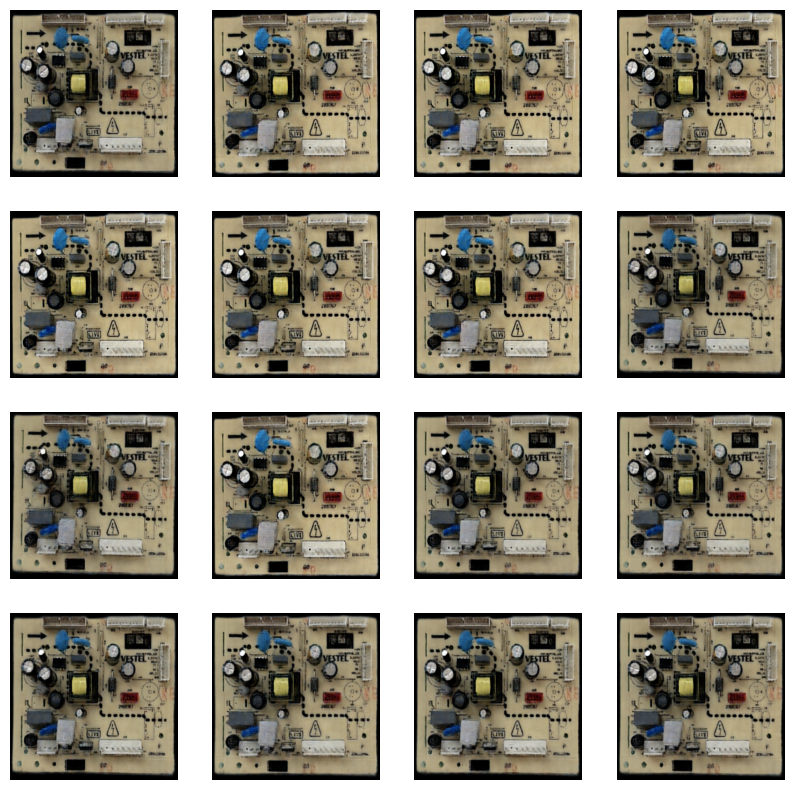

In [ ]:
generated_train_data = autoencoder_model.predict(train_dataset_part)

show_generated_images(generated_train_data)

Difference map shape: (512, 512, 3)
Normalized difference map shape: (512, 512, 3)
Normalized difference map min, avg, max value: (9.984263726892095e-08, 0.05141, 1.0)
Colored difference map shape: (512, 512, 3, 4)


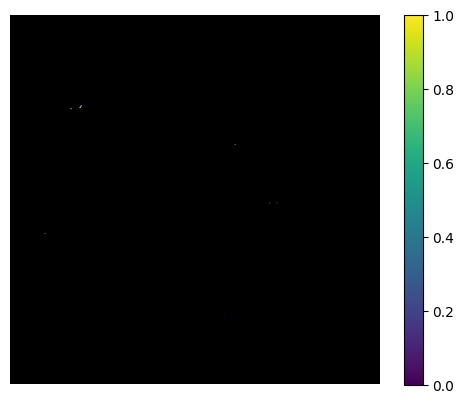

In [ ]:
train_batch, _ = next(iter(train_dataset_part))

display_pixel_wise_img_diff(train_batch[0], generated_train_data[0], threshold=0.8, channel=0, verbose=1)

1/1 [==============================] - 2s 2s/step
Computing min and max...
max_norm: 2328.490478515625
min_norm: 0.0
Calculating anomaly map


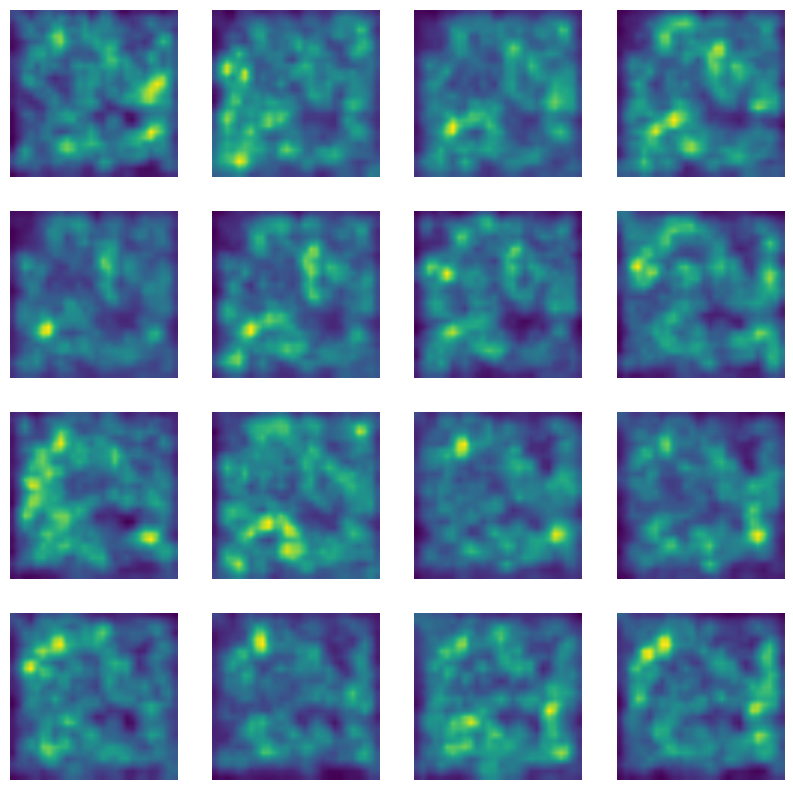

In [ ]:
# Predict all images for training data
# y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred = predict_perpdiff(test_dataset, autoencoder_model)
y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred = predict_perpdiff(train_dataset, train_dataset_part, autoencoder_model)

# Get min max for normalization
min_norm, max_norm = compute_min_max(perp_input, perp_pred)

# Calculate perceptual anomaly map
all_perp, y_pred_all = calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm)
show_generated_images(all_perp)

### Generate Images from Validation Data

1/1 [==============================] - 0s 123ms/step


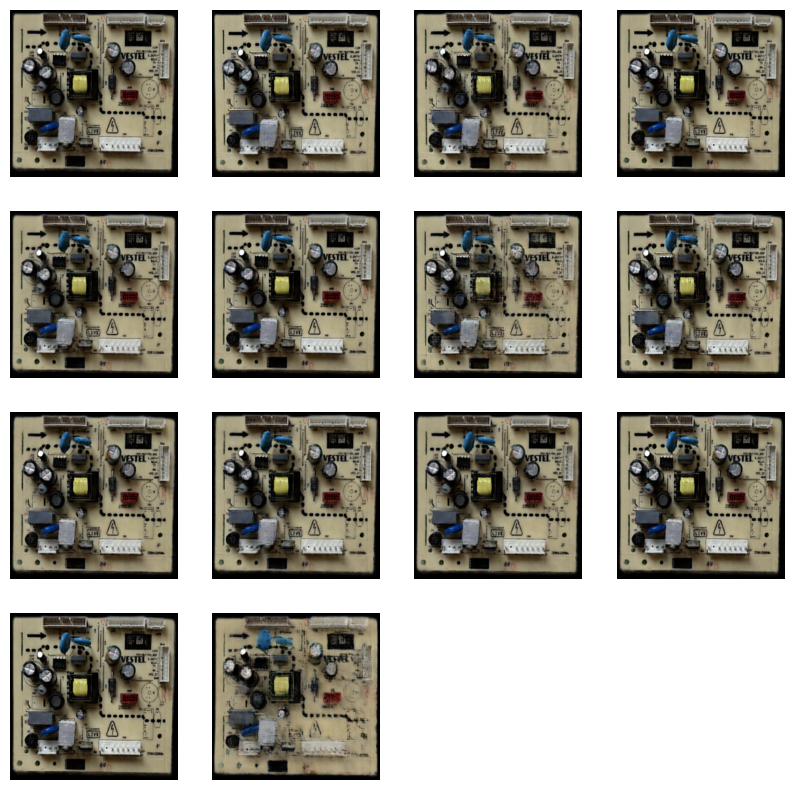

In [ ]:
generated_valid_data = autoencoder_model.predict(valid_dataset_part)

show_generated_images(generated_valid_data)

Difference map shape: (512, 512, 3)
Normalized difference map shape: (512, 512, 3)
Normalized difference map min, avg, max value: (3.369049395018919e-08, 0.05576, 1.0)
Colored difference map shape: (512, 512, 3, 4)


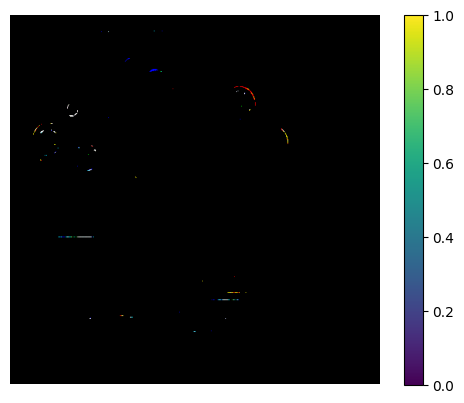

In [ ]:
valid_batch, _ = next(iter(valid_dataset_part))

display_pixel_wise_img_diff(valid_batch[1], generated_valid_data[1], threshold=0.8, channel=0, verbose=1)

1/1 [==============================] - 0s 204ms/step
Computing min and max...
max_norm: 4552.07177734375
min_norm: 0.0
Calculating anomaly map


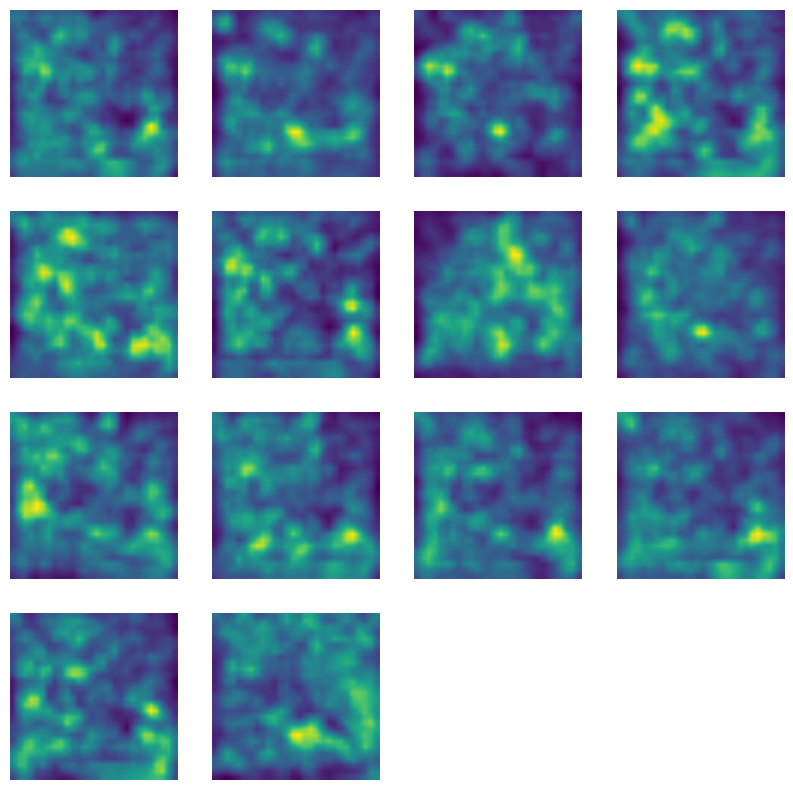

In [ ]:
# Predict all images for training data
# y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred = predict_perpdiff(test_dataset, autoencoder_model)
y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred = predict_perpdiff(valid_dataset_part, valid_dataset_part, autoencoder_model)

# Get min max for normalization
min_norm, max_norm = compute_min_max(perp_input, perp_pred)

# Calculate perceptual anomaly map
all_perp, y_pred_all = calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm)
show_generated_images(all_perp)

Create Test Dataset

In [ ]:
test_images = utils.get_all_img_files_in_directory(BD67_DEFECTED_FRONT_PATH, "png")

In [ ]:
#test_dataset = utils.create_dataset_pipeline(test_images, batch_size=experiment['BATCH_SIZE'])
test_dataset = utils.create_dataset_pipeline(test_images, batch_size=experiment['BATCH_SIZE'], img_size=experiment['IMAGE_SIZE'], scl=True, shuffle=False, num_channels=3, rot=utils.ROT_0, duplicate=True, aug_layer=None, data_aug_power=1, accelerator='GPU')

### Generate Images from Testing Data

1/1 [==============================] - 0s 397ms/step


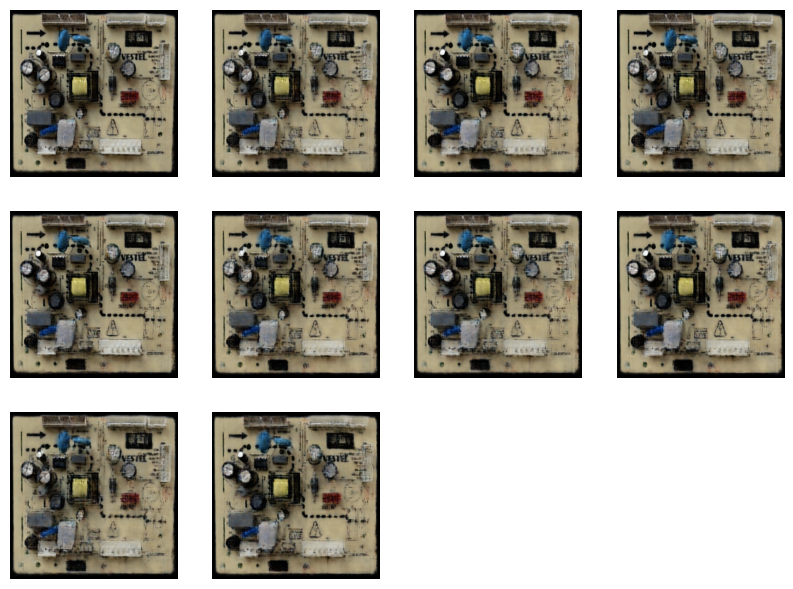

In [ ]:
generated_test_data = autoencoder_model.predict(test_dataset)

show_generated_images(generated_test_data)

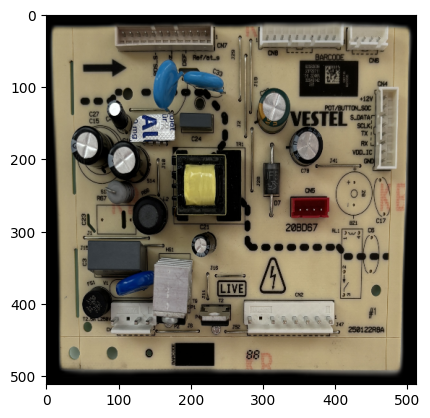

In [ ]:
plt.imshow(test_batch[0])

Difference map shape: (512, 512, 3)
Normalized difference map shape: (512, 512, 3)
Normalized difference map min, avg, max value: (4.942644338257196e-08, 0.09414, 1.0)
Colored difference map shape: (512, 512, 3, 4)


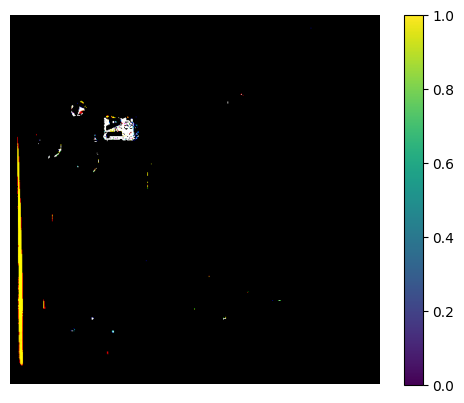

In [ ]:
test_batch, _ = next(iter(test_dataset))

display_pixel_wise_img_diff(test_batch[0], generated_test_data[0], threshold=0.8, channel=0, verbose=1)

1/1 [==============================] - 0s 135ms/step
Computing min and max...
max_norm: 5575.30029296875
min_norm: 0.0
Calculating anomaly map


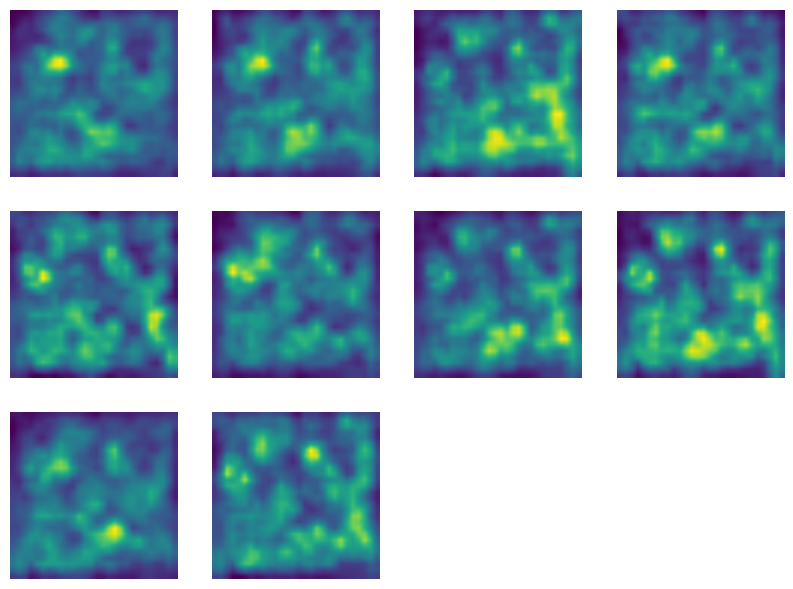

In [ ]:
# Predict all images
# y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred = predict_perpdiff(test_dataset, autoencoder_model)
y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred = predict_perpdiff(test_dataset, test_dataset, autoencoder_model)

# Get min max for normalization
min_norm, max_norm = compute_min_max(perp_input, perp_pred)

# Calculate perceptual anomaly map
all_perp, y_pred_all = calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm)
show_generated_images(all_perp)